# Training fine flow prediction
Assuming source image $I_s$ and target image $I_t$ are already coarsely aligned, this notebook will try to predict a fine flow $F_{s\rightarrow t}$ between them. 

TODO describe objective functions used in this project

In [1]:
%load_ext autoreload
%autoreload 2

We assume you already have a folder called `workspace` that contains zipped dataset.

In [2]:
%cd ../notebooks/workspace

/mnt/d/courses/RANSAC-Flow/notebooks/workspace


Import packages that we will use throughout this notebook.

In [3]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

We enable logging here to make debug easier. 

In [4]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s] %(name)s :: %(levelname)s :: %(message)s",
    handlers=[logging.StreamHandler()],
)

logging.getLogger("ransacflow").setLevel(logging.DEBUG)

## Prepare dataset
We already pack some datasets used in the original paper as `LightningDataModule`. We will import it here.

In [5]:
from ransacflow.data import MegaDepthDataModule

image_size = 224
mega_depth = MegaDepthDataModule(
    "MegaDepth_cleansed.zip", image_size=image_size, train_batch_size=2
)

In [ ]:
#TODO add some sanity check for the dataset here, previews

In [ ]:
# TODO setup environments for the following training sessions, how?

In [ ]:
# FIXME is it possible to share the Trainer object across all 3 stages

## Stage 1
Only train the **reconstruction loss**. 

It is based on the idea that source image $I_s$ warped with the predicted flow $F_{s\rightarrow t}$ should align well with the target image $I_t$. In the original work, they use the structural similarity (SSIM) as the perception model. 
$$ L_{\text{recon}}\left(I_s, I_t\right) = \sum_{(x,y)\in I_t} M_t^{\text{cycle}}(x,y) \left( 1 - \text{SSIM}\left\lbrace I_s(x^\prime, y^\prime), I_t(x,y) \right\rbrace \right) $$

FIXME wtf is M_t doing here?

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 3 batch(es).
/home/andy/.conda/envs/ransacflow/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                  | Params
------------------------------------------------------------
0 | feature_extractor | FeatureExtractor      | 2.8 M 
1 | correlator        | NeighborCorrelator    | 0     
2 | flow              | FlowPredictor         | 1.8 M 
3 | matchability      | MatchabilityPredictor | 1.7 M 
4 | loss_rec          | ReconstructionLoss    | 0     
--------------------------------------------------------

Training: 0it [00:00, ?it/s]

[2021-12-21 01:58:16,545] ransacflow.train :: DEBUG :: create new grid torch.Size([224, 224])


Validating: 0it [00:00, ?it/s]

[2021-12-21 01:58:17,825] ransacflow.data.transform :: DEBUG :: initial_ratio=4.821428571428571, actual_ratio=(w=5.0, h=4.821428571428571)
[2021-12-21 01:58:17,899] ransacflow.data.transform :: DEBUG :: initial_ratio=4.821428571428571, actual_ratio=(w=5.0, h=4.821428571428571)
[2021-12-21 01:58:17,937] ransacflow.train :: DEBUG :: create new grid torch.Size([224, 384])


*** tgt_feat
tensor([[34.6773, 22.9684],
        [57.5252,  9.3294],
        [66.2056, 23.0361],
        [31.1992, 20.8162],
        [67.1156,  9.7226],
        [58.6508,  8.8089],
        [67.3844, 10.8794],
        [59.4148, 22.3646],
        [59.8348,  7.4765],
        [66.8844,  8.0827]], device='cuda:0')
src_feat.shape=torch.Size([1, 93, 2]), src_feat_F.shape=torch.Size([1, 93, 2]), diff.shape=torch.Size([1, 93])
src_feat[5]=tensor([[[36., 28.],
         [61.,  8.],
         [63.,  3.],
         [43., 28.],
         [69.,  8.]]], device='cuda:0')
src_feat_F[5]=tensor([[[135.4529,  88.6001],
         [184.5524,  48.6023],
         [191.3091,  39.4047],
         [149.2974,  88.6237],
         [198.4032,  48.6151]]], device='cuda:0')
diff[5]=tensor([[116.4613, 130.0528, 133.3736, 122.3698, 135.6273]], device='cuda:0')


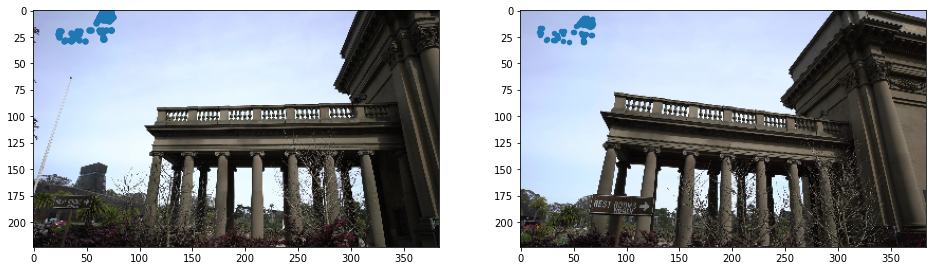

RuntimeError: DEBUG, base, validation_step, non-iterative

In [7]:
# DEBUG somehow dataset needs to reload everythime for correct coords
from ransacflow.data import MegaDepthDataModule

image_size = 224
mega_depth = MegaDepthDataModule(
    "MegaDepth_cleansed.zip", image_size=image_size, train_batch_size=2
)

## parameter names
log_dir = "MegaDepth_logs"
##

from ransacflow.train import RANSACFlowModelStage1

ransac_flow = RANSACFlowModelStage1(
    alpha=0, beta=0, gamma=0, kernel_size=7, ssim_window_size=11, lr=2e-4,
)

# FIXME unify TB logging location and experiment name
trainer = Trainer(
    gpus=-1,
    fast_dev_run=3,
    max_epochs=200,
    logger=TensorBoardLogger(log_dir, name="stage1"),
    callbacks=[EarlyStopping(monitor="val_loss", min_delta=0.01, patience=3)],
)
trainer.fit(ransac_flow, mega_depth)


All following command line interface are copied from the original implementation, temporarily.

In [ ]:
    --nEpochs 200 
    --lr 2e-4
    --kernelSize 7 
--imgSize 224 
--batchSize 16 
    --lambda-match 0.0, alpha 
    --mu-cycle 0.0, beta 
    --grad 0.0, gamma  
    --trainMode flow 
--margin 88 

## Stage 2
Train jointly the **reconstruction loss** and **cycle consistency of the flow**.

Asides from the reconstruction loss mentioned in previous stage, we start to enforce cycle consistency of the flow by
$$ L_{\text{cycle}} = \sum_{(x,y) \in I_t} M_t^{\text{circle}} (x,y) \left\lVert \left(x^\prime, y^\prime \right), \bm{F}_{t\rightarrow s}(x,y) \right\rVert_2 $$

FIXME what happened with (x^\prime, y^\prime), F_{t->s}? Are they multiplied?

In [ ]:
from ransacflow.train import RANSACFlowModelStage2

ransac_flow = RANSACFlowModelStage2(alpha=0, beta=1, gamma=0, kernel_size=7, lr=2e-4)

# FIXME unify TB logging location and experiment name
trainer = Trainer(
    max_epochs=50,
    logger=TensorBoardLogger("tb_logs", name="RANSAC-Flow_stage2"),
    callbacks=[EarlyStoppping(monitor="val_loss", min_delta=0.01, patience=3)],
)
trainer.fit(ransac_flow, MegaDepthDataModule)

In [ ]:

    --nEpochs 50 
    --lr 2e-4 
    --kernelSize 7 
--imgSize 224 
--batchSize 16 
    --lambda-match 0.0, alpha
    --mu-cycle 1.0, beta
    --grad 0.0, gamma
    --trainMode flow 
--margin 88 

## Stage 3
Train all three losses together: **reconstruction loss**, **cycle consistency of the flow**, and **matchability loss**.

Matchability mask can be seen as pixel-wise weights for the reconstruction and cycle consistency loss. These losses encourage th matchability to be zero. To counteract this effect, the matchability loss encourages the matchability mask to be close to one.

FIXME equation for matchability
FIXME still doesn't understand what matchability actually implies, what is the difference between this and cycle loss?

In [ ]:
from ransacflow.train import RANSACFlowModelStage3

ransac_flow = RANSACFlowModelStage3(alpha=0.01, beta=1, gamma=0, kernel_size=7, lr=2e-4)

# FIXME unify TB logging location and experiment name
trainer = Trainer(
    max_epochs=50,
    logger=TensorBoardLogger("tb_logs", name="RANSAC-Flow_stage3"),
    callbacks=[EarlyStoppping(monitor="val_loss", min_delta=0.01, patience=3)],
)
trainer.fit(ransac_flow, MegaDepthDataModule)


In [ ]:
    --nEpochs 50 
    --lr 2e-4
    --kernelSize 7 
--imgSize 224 
--batchSize 16 
    --lambda-match 0.01, alpha
    --mu-cycle 1.0, beta
    --grad 0.0, gamma
    --trainMode flow+match 
--margin 88 


## Stage 4.1
This additional stage fine tune on SOMETHING MAGICAL, so the output image introduce less distortions.

TODO need to update description from the original paper

## Stage 4.2
This additional stage uses perceptual loss, 

TODO add description about why and how to use perceptual loss